# Anomaly detection in time-series : reconstruction
This notebook demonstrates anomaly detection in time series using reconstruction methods. Anomaly detection by reconstruction involves training models to reconstruct the values of a time series and identifying anomalies based on deviations between the reconstructed and actual values. We cover autoencoder-based techniques here.

## Necessary imports

In [1]:
from typing import List, Dict
import warnings

import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Plot
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Custom modules
from data_preprocessing import DataPreprocessor, SimpleDataSet, DataLoaderNAB
from base_torch_models import Network


torch.set_default_dtype(torch.float32)
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data
To compare each model, we will use real-life data from the [NAB dataset][nab].

[nab]: https://github.com/numenta/NAB

The specific data used in this notebook is from the `realAdExchange/exchange-3_cpc_results` file. This dataset contains timestamped values representing the cost-per-click (CPC) results over a period of time. The dataset includes:

- `timestamp`: The date and time of the recorded value.
- `value`: The CPC value recorded at the corresponding timestamp.

We will use this data to train and evaluate our anomaly detection models.


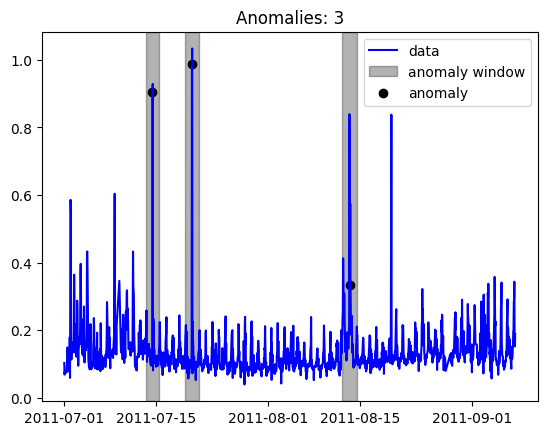

In [2]:
# Use convenience functions to load and visualize the time series
df, anomaly_times, anomaly_windows = DataLoaderNAB.load_data('data.csv', 'anomaly_times.json', 'windows.json')

U = [] # we don't have any external features
Y = df["value"].values

fig, ax = plt.subplots()
DataLoaderNAB.plot_series(df, anomaly_times, anomaly_windows, ax=ax);

In [3]:
# Configurations of the models and the training scheme
n_window = 5 # sequence length for the autoencoder
test_size = 0.3 # percentage of the dataset to use as test set
batch_size = 1.0 # percentage of the training dataset to use as batch size
mlp_activation_fn = torch.relu # activation function for the MLP


def create_AE_dataset(Y, n_window=1, test_size=0.1):
    Ydata = DataPreprocessor.create_AE_model(Y, n_window=n_window)
    Ydata = torch.tensor(Ydata, dtype=torch.float32)

    Ytrain, Yval, = train_test_split(Ydata, test_size=test_size, shuffle=True)

    return Ytrain, Yval, Ydata

def create_dataloaders(Ytrain, Yval, batch_size=10):
    n_samples = len(Ytrain)
    n_batch = round(batch_size * n_samples)
    assert n_batch > 1, "Batch normalization of the model requires batch size greater than 1!"

    train_dl = DataLoader(SimpleDataSet(Ytrain, Ytrain), batch_size=n_batch, shuffle=True)
    val_dl =  DataLoader(SimpleDataSet(Yval, Yval), batch_size=n_batch, shuffle=True)

    return train_dl, val_dl

Ytrain, Yval, Ydata = create_AE_dataset(Y, n_window = 5, test_size=test_size)
train_dl, val_dl = create_dataloaders(Ytrain, Yval, batch_size=batch_size)

## Method: Autoencoder

We have defined two models: an AutoEncoder and an LSTM AutoEncoder. The training process involves minimizing the reconstruction error on the training set and evaluating the performance on the validation set.

- **AutoEncoder**: A feedforward neural network that is typically used for tasks where the input data is not sequential. It consists of an encoder that compresses the input data into a latent-space representation and a decoder that reconstructs the input data from this representation.

- **LSTM AutoEncoder**: LSTM networks are designed to handle sequential data and can capture temporal dependencies. The LSTM AutoEncoder is particularly useful for tasks involving time-series data, where the order of the data points is important. It consists of an LSTM encoder that processes the input sequence and compresses it into a latent representation, and an LSTM decoder that reconstructs the sequence from this representation.

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, sequence_length, encoder_layers_list: List, decoder_layers_list: List, activation_fn):
        super().__init__()
        encoder_layers_list.insert(0, sequence_length)
        self.encoder = Network(encoder_layers_list, activation_fn)
        decoder_layers_list.insert(0, encoder_layers_list[-1])
        decoder_layers_list.append(encoder_layers_list[0])
        self.decoder = Network(decoder_layers_list, activation_fn)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class LSTMAutoEncoder(nn.Module):
    def __init__(self,lstm_args: Dict, fc_args: Dict):
        super().__init__()
        self.encoder = nn.LSTM(**lstm_args)
        # if encoder_args["hidden_size"] != decoder_args.get("input_size",None):
            # warnings.warn("Input size of the decoder network must be output size of the encoder network, adjusting decoder arguments accordingly")
            # decoder_args["input_size"] = encoder_args["hidden_size"]
        self.decoder = nn.LSTM(**lstm_args)
        self.h2o = Network(**fc_args)

    def forward(self, x):
        is_2d = False
        if x.ndim == 2:
            # Input is given as (batch_size, sequence_length), map to (batch_size, sequence_length, n_features)
            x = x.view(x.shape[0], x.shape[1], 1)
            is_2d = True
        # Encoding
        _, hidden_states = self.encoder(x)
        # Decoding
        decoder_input = x[:,-1,:].view(x.shape[0], 1, x.shape[2])
        output_sequence = torch.zeros(size=x.shape, dtype=torch.float32)
        for i in range(x.shape[1]-1, -1, -1):
            decoder_out, hidden_states = self.decoder(decoder_input, hidden_states)
            predicted_sequence = self.h2o(decoder_out[:, -1, :])
            output_sequence[:,i,:] = predicted_sequence
            decoder_input = predicted_sequence.view(predicted_sequence.shape[0], 1, predicted_sequence.shape[1])

        if is_2d:
            return output_sequence.view(output_sequence.shape[0], output_sequence.shape[1])
        else:
            return output_sequence



In [5]:
# Create convenience functions for training and testing the model

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model_lstm to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        if isinstance(X, torch.Tensor):
            pred = model(X)
        else:
            pred = model(*X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    loss = loss.item()
    return loss


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0.0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            if isinstance(X, torch.Tensor):
                pred = model(X)
            else:
                pred = model(*X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

def fit_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs = 1, log_interval = None):
    loss_train = []
    loss_val = []
    if not log_interval:
        log_interval = round(epochs * 0.1)
    for t in range(epochs):
        loss_t = train_loop(train_dataloader, model, loss_fn, optimizer)
        loss_v = test_loop(test_dataloader, model, loss_fn)
        loss_train.append(loss_t)
        loss_val.append(loss_v)

        if t % log_interval == 0:
            print(f"Epoch {t+1}, Train loss = {loss_t}, Test loss = {loss_v} \n-------------------------------")
    return loss_train, loss_val

In [6]:
# Create models
autoencoder = AutoEncoder(
    sequence_length=n_window,
    encoder_layers_list=[32, 10],
    decoder_layers_list=[32],
    activation_fn= torch.relu)

lstm_args = {
    'input_size':Y.ndim,
    'hidden_size':40,
    'batch_first':True
}

fc_args = {'n_nodes_list':[40, Y.ndim],}
lstm_autoencoder = LSTMAutoEncoder(lstm_args, fc_args)

In [7]:
# Train models and check validation loss
loss_fn = nn.MSELoss()
optimizer_ae = torch.optim.Adam(autoencoder.parameters())
optimizer_ae_lstm = torch.optim.Adam(lstm_autoencoder.parameters())
epochs =201

loss_train_lstm, loss_val_lstm = fit_loop(train_dl, val_dl, autoencoder, loss_fn, optimizer_ae, epochs)
loss_train_net, loss_val_net = fit_loop(train_dl, val_dl, lstm_autoencoder, loss_fn, optimizer_ae_lstm, epochs)

Epoch 1, Train loss = 0.25542065501213074, Test loss = 0.05584065243601799 
-------------------------------
Epoch 21, Train loss = 0.04203267768025398, Test loss = 0.025576109066605568 
-------------------------------
Epoch 41, Train loss = 0.015794068574905396, Test loss = 0.010464292019605637 
-------------------------------
Epoch 61, Train loss = 0.00820818729698658, Test loss = 0.006379884202033281 
-------------------------------
Epoch 81, Train loss = 0.005255648400634527, Test loss = 0.0049605779349803925 
-------------------------------
Epoch 101, Train loss = 0.0038510551676154137, Test loss = 0.0039836042560637 
-------------------------------
Epoch 121, Train loss = 0.002998239593580365, Test loss = 0.0032698442228138447 
-------------------------------
Epoch 141, Train loss = 0.0024318781215697527, Test loss = 0.0027615847066044807 
-------------------------------
Epoch 161, Train loss = 0.002047125715762377, Test loss = 0.002382259350270033 
-------------------------------

In [8]:
# Get prediction error from themodels
autoencoder.eval()
lstm_autoencoder.eval()
df_plot = pd.DataFrame()
df_plot["timestamp"] = df["timestamp"][n_window-1:]
df_plot["value"] = df["value"][n_window-1:]
Y_tensor = Ydata.clone().detach()
with torch.no_grad():
    y_pred_ae = autoencoder(Y_tensor)
    y_pred_lstm_ae = lstm_autoencoder(Y_tensor)

pred_error_ae = df_plot["value"] - y_pred_ae[:,0].numpy().squeeze()
pred_error_lstm_ae = df_plot["value"] - y_pred_lstm_ae[:,0].numpy().squeeze()


In [15]:
def plot_results_training(axs, y_pred, loss_train, loss_val, model_name, color):
    # plot predicted result
    axs[0].plot(y_pred, label=f'Predicted time series - {model_name}', color=color)
    axs[0].set_xlabel('time index')
    axs[0].legend()

    axs[1].plot(np.array(loss_train), label=f'Train loss - {model_name}', color=color, linestyle='solid')
    axs[1].plot(np.array(loss_val), label=f'Validation loss - {model_name}', color=color, linestyle='dashed')
    axs[1].set_xlabel('Epochs')
    axs[1].legend()
    return axs

def plot_results_timeseries(fig:go.Figure, df, y_pred, pred_error, anomaly_times, anomaly_windows, n_lag):
    # Add time series
    fig.add_trace(go.Scatter(x=df["timestamp"], y=df["value"], mode='lines', name='Time series'))

    # Add reconstruction
    fig.add_trace(go.Scatter(x=df["timestamp"][n_lag:], y=np.squeeze(y_pred.numpy()), mode='lines', name='Prediction'))

    # Add prediction error
    fig.add_trace(go.Scatter(x=df["timestamp"][n_lag:], y=pred_error, mode='lines', name='Prediction error'))
    # Add anomaly windows
    for window in anomaly_windows:
        fig.add_shape(
            type="rect",
            x0=window[0],
            y0=-float('inf'),
            x1=window[1],
            y1=float('inf'),
            fillcolor="red",
            opacity=0.3,
            line_width=0,
        )
    # Add anomalies
    for anomaly_time in anomaly_times:
        fig.add_shape(
            type="line",
            x0=anomaly_time,
            y0=-float('inf'),
            x1=anomaly_time,
            y1=float('inf'),
            line=dict(dash="dash")
        )
    fig.add_trace(go.Scatter(
        x=anomaly_times,
        y=np.zeros_like(anomaly_times, dtype=np.float32),
        mode='markers',
        marker=dict(color='black'),
        name='Anomaly'
    ))
    fig.update_layout(title='Time Series with Prediction Error and Anomalies', xaxis_title='Timestamp', yaxis_title='Value')
    return fig

def plot_results_timeseries_matplotlib(ax, df, y_pred, pred_error, anomaly_times, anomaly_windows, n_lag):
    # Add time series
    ax.plot(df["timestamp"], df["value"], label='Time series', color='black')

    # Add reconstruction
    ax.plot(df["timestamp"][n_lag:], np.squeeze(y_pred.numpy()), label='Prediction', color='blue')

    # Add prediction error
    ax.plot(df["timestamp"][n_lag:], pred_error, label='Prediction error', color='red')

    # Add anomaly windows
    for window in anomaly_windows:
        ax.axvspan(window[0], window[1], color='red', alpha=0.3)

    # Add anomalies
    for anomaly_time in anomaly_times:
        ax.axvline(anomaly_time, color='black', linestyle='dashed')

    ax.legend()
    ax.set_title('Time Series with Prediction Error and Anomalies')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Value')
    return ax



array([<Axes: xlabel='time index'>, <Axes: xlabel='Epochs'>], dtype=object)

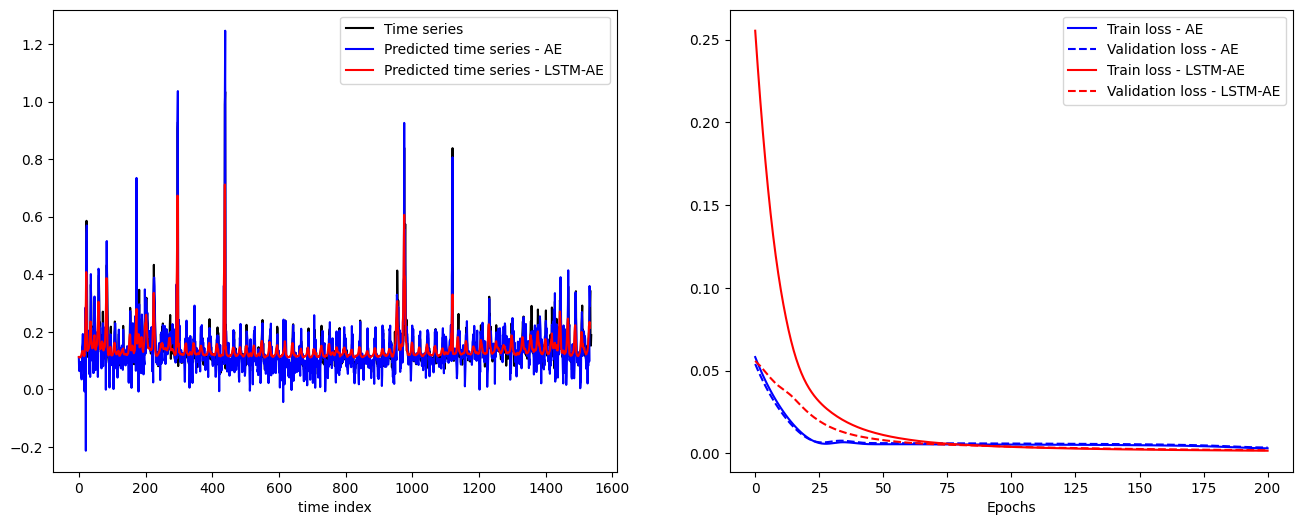

In [10]:
fig1, axs = plt.subplots(1, 2, figsize=(16, 6))
# Plot true time series once

axs[0].plot(df_plot["value"], color='k', label='Time series')

plot_results_training(axs, y_pred_ae[:,0], loss_train_net, loss_val_net, "AE", color='b')
plot_results_training(axs, y_pred_lstm_ae[:,0], loss_train_lstm, loss_val_lstm, "LSTM-AE", color='r')

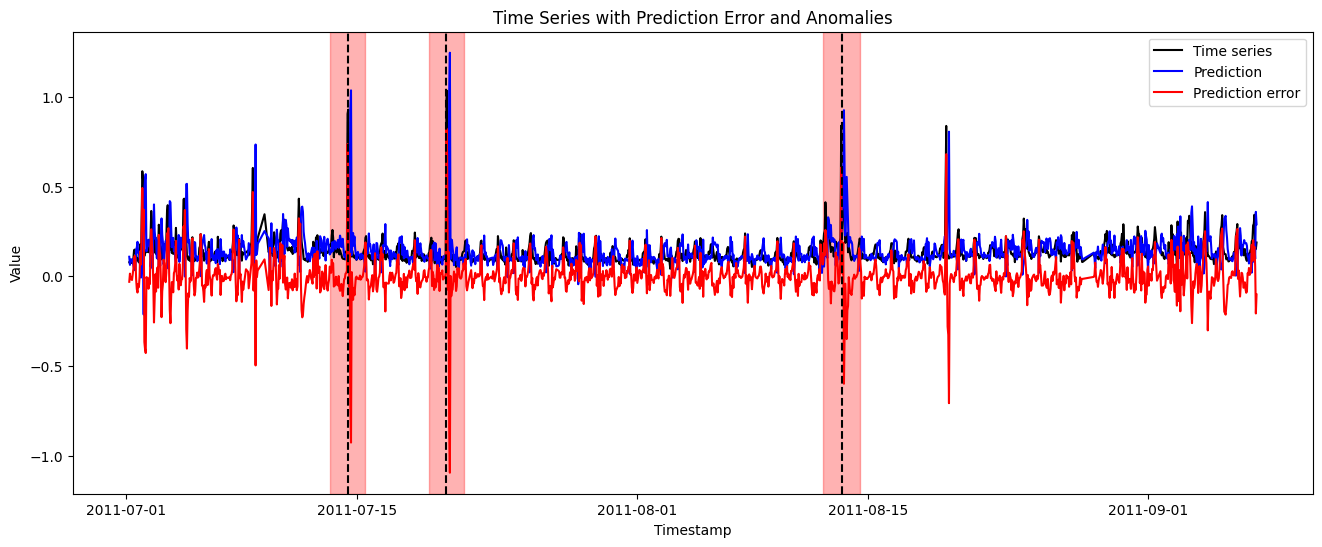

In [19]:
fig = go.Figure()
fig = plot_results_timeseries(fig, df_plot, y_pred_ae[:,0], pred_error_ae, anomaly_times, anomaly_windows, 0)
fig.show()

# Some browsers may not display the plotly figures, for those cases, showing the matplotlib figures
fig, ax = plt.subplots(figsize=(16, 6))
plot_results_timeseries_matplotlib(ax, df_plot, y_pred_ae[:,0], pred_error_ae, anomaly_times, anomaly_windows, 0);

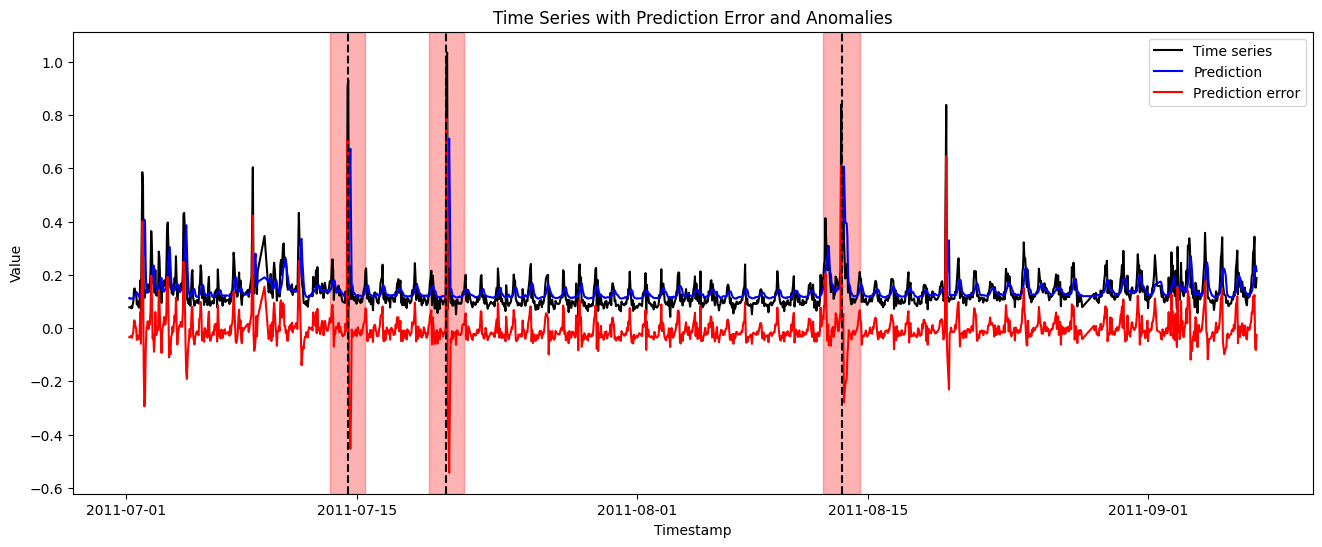

In [20]:
fig = go.Figure()
fig = plot_results_timeseries(fig, df_plot, y_pred_lstm_ae[:,0], pred_error_lstm_ae, anomaly_times, anomaly_windows, 0)
fig.show()

# Some browsers may not display the plotly figures, for those cases, showing the matplotlib figures
fig, ax = plt.subplots(figsize=(16, 6))
plot_results_timeseries_matplotlib(ax, df_plot, y_pred_lstm_ae[:,0], pred_error_lstm_ae, anomaly_times, anomaly_windows, 0);